In [1]:
# first install 
# conda create -n barotropic -c conda-forge pyspharm numpy netcdf4 jupyterlab xarray matplotlib windspharm scipy xesmf
# scipy is for interpolation
# more interpolation problems: a specific version of esmpy
# conda install -c conda-forge xesmf esmpy=8.0.0
# optional cartopy for map displays here, or use IDV on output files

In [2]:
from datetime import datetime

import netCDF4
import numpy as np
import xarray as xr

import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display
# import cartopy to put coastlines on plots 

from barotropic.model import BarotropicModel
from barotropic.io import NetCDFWriter

# https://ajdawson.github.io/windspharm/latest/ for streamfunction displays and perhaps u&v edits 
import windspharm

In [3]:
hour = 3600
run_time = 5 * 24 * hour 
output_interval = 6 * hour

## A realistic initial condition


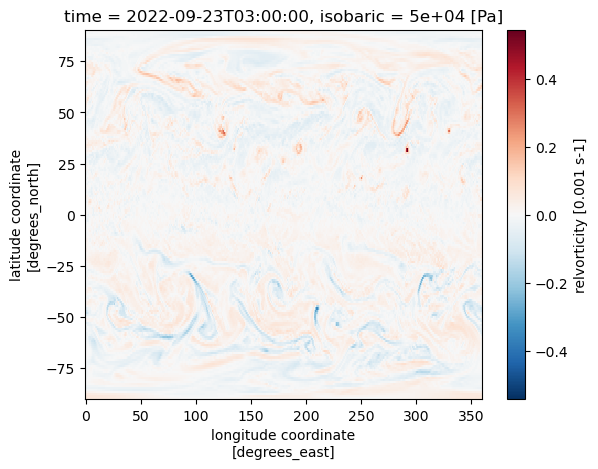

In [4]:
ds = xr.open_dataset('GFS_1deg_Ian2022_vrt.nc')
GFS_init = ds.relvorticity[0,0,:,:] # The first time level
GFS_init.plot()

In [5]:
# GFS_init

## Need to interpolate onto Gaussian N80 grid from example

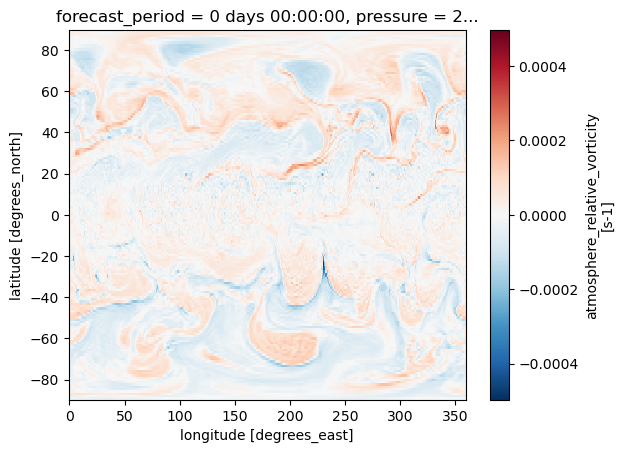

In [6]:
# Load initial condition from file:
example = xr.open_dataset('input_data/ecmwf.201611010000.nc')
vrt = example.atmosphere_relative_vorticity
nlat, nlon = vrt.shape
truncation = nlon // 3
vrt.plot()

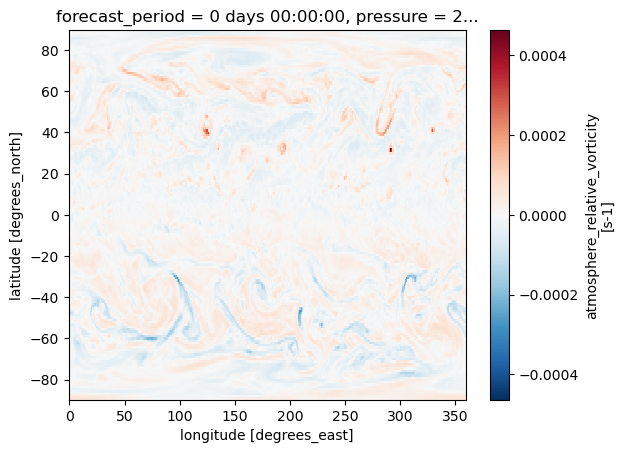

In [7]:
# Interpolate GFS data onto the ecmwf (vrt) grid 
vrt.data = GFS_init.interp(lat=vrt.latitude, lon=vrt.longitude).values/1000.
vrt.plot()

In [8]:
# OLD STUFF from Interpolate vor_init onto vrt grid 
# https://docs.xarray.dev/en/stable/generated/xarray.DataArray.interp_like.html doesnt work! Why? GRR
# vrt = vrt.rename({'longitude': 'lon','latitude': 'lat'})
# http://www.matteodefelice.name/post/c3s-multimodel/ says use xesmf 
# GRRR SOME KIND OF MPI THING BROKE MY ENVIRONMENT@!! 

In [9]:
# Calculate distance from a specific spot, to use for making a vorticity perturbation
import numpy as np

spec_lon = 300
spec_lat = 30 

vortpert = vrt.copy()*0
lat = np.array(vrt.latitude)
lon = np.array(vrt.longitude)
# now make a Gaussian bell from distance
distance = np.sqrt((lat - spec_lat)[:,None]**2 + ((lon - spec_lon)**2)) #*np.cos(lat) 
vortpert.data = 1.0E-5 *np.exp( -distance**2/100 ) # 10 degree scale Gaussian blob 

#vortpert.plot()

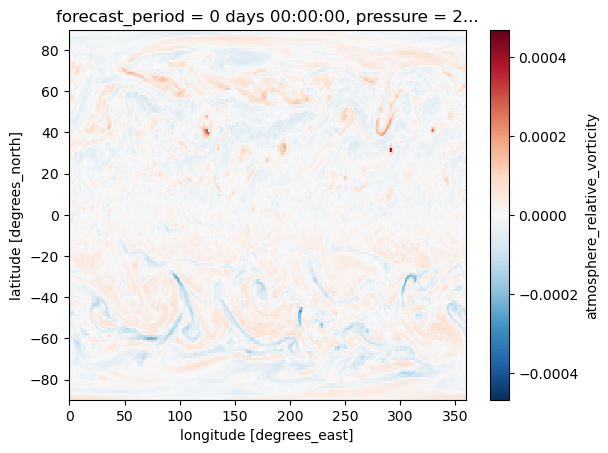

In [10]:
newvrt = vrt + (vortpert-vortpert.mean())
newvrt.plot()
newvrt.to_netcdf('GFS_initvor_on_ECgrid.nc')

# OK, read the newvort (same as the old vort) as NetCDF, and try it

In [11]:
dsold = netCDF4.Dataset('input_data/ecmwf.201611010000.nc')
vrtNC = dsold.variables['atmosphere_relative_vorticity'][:]
vrtNC.min()

-0.0004968319553881884

In [12]:
ds = netCDF4.Dataset('GFS_initvor_on_ECgrid.nc')
vrt_new = ds.variables['atmosphere_relative_vorticity'][:]
vrt_new.min()

-0.0002713493636276108

In [13]:
GFS_init.time.values

# import pandas as pd 
#start_time = pd.to_datetime(vor_init.time.values)

numpy.datetime64('2022-09-23T03:00:00.000000000')

In [14]:
# Run length and output interval
#hour = 3600
#run_time = 5 * 24 * hour 
#output_interval = 6 * hour
# Use a 900 second time-step, based on example 

dt = 900
start_time = datetime(2022, 9, 23, 3)

ds = netCDF4.Dataset('GFS_initvor_on_ECgrid.nc')
vrt = ds.variables['atmosphere_relative_vorticity'][:]

# Load initial condition from file:
nlat, nlon = vrt.shape
truncation = nlon // 3

# Create the model and a saver:
model_GFS = BarotropicModel(vrt, truncation, dt, start_time)
saver_GFS = NetCDFWriter(model_GFS, 'output_GFS.nc')

# Run the model (same method as before)
for t in model_GFS.run_with_snapshots(
        run_time, snapshot_interval=output_interval):
    print('Saving output at time: {}'.format(model_GFS.valid_time))
    saver_GFS.save()
saver_GFS.close()

Saving output at time: 2022-09-23 09:00:00
Saving output at time: 2022-09-23 15:00:00
Saving output at time: 2022-09-23 21:00:00
Saving output at time: 2022-09-24 03:00:00
Saving output at time: 2022-09-24 09:00:00
Saving output at time: 2022-09-24 15:00:00
Saving output at time: 2022-09-24 21:00:00
Saving output at time: 2022-09-25 03:00:00
Saving output at time: 2022-09-25 09:00:00
Saving output at time: 2022-09-25 15:00:00
Saving output at time: 2022-09-25 21:00:00
Saving output at time: 2022-09-26 03:00:00
Saving output at time: 2022-09-26 09:00:00
Saving output at time: 2022-09-26 15:00:00
Saving output at time: 2022-09-26 21:00:00
Saving output at time: 2022-09-27 03:00:00
Saving output at time: 2022-09-27 09:00:00
Saving output at time: 2022-09-27 15:00:00
Saving output at time: 2022-09-27 21:00:00
Saving output at time: 2022-09-28 03:00:00


(array([1.32000e+02, 1.53400e+03, 1.25330e+04, 1.67967e+05, 6.39957e+05,
        1.91366e+05, 9.80400e+03, 6.54000e+02, 4.00000e+01, 1.30000e+01]),
 array([-1.59936098e-04, -1.24320592e-04, -8.87050774e-05, -5.30895632e-05,
        -1.74740526e-05,  1.81414580e-05,  5.37569686e-05,  8.93724791e-05,
         1.24987986e-04,  1.60603508e-04,  1.96219014e-04]),
 <BarContainer object of 10 artists>)

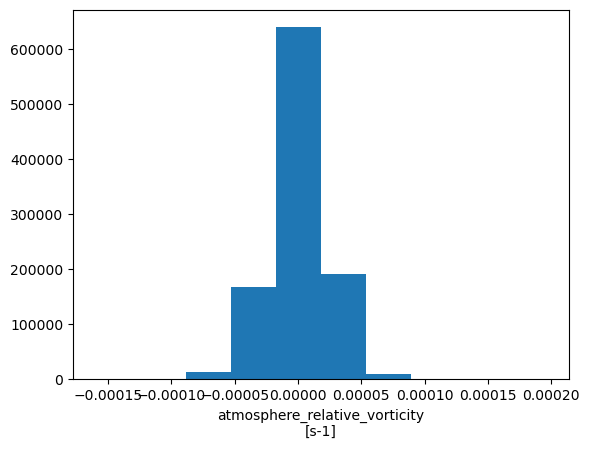

In [15]:
df = xr.open_dataset('output_GFS.nc')
df.vrt.plot()

# Animate the results

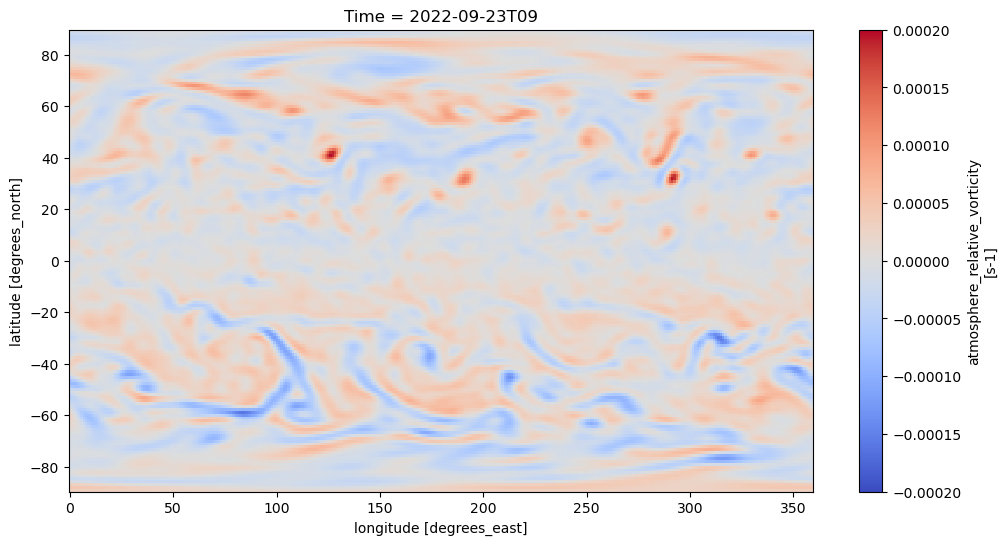

In [17]:
# from https://climate-cms.org/posts/2019-09-03-python-animation.html
tas = df.vrt # to match the code exactly from example

# Get a handle on the figure and the axes
fig, ax = plt.subplots(figsize=(12,6))

# Plot the initial frame. 
cax = tas[0,:,:].plot(
    add_colorbar=True,
    cmap='coolwarm',
    vmin=-0.0002, vmax=0.0002,
    cbar_kwargs={
        'extend':'neither'
    }
)

# Next we need to create a function that updates the values for the colormesh, as well as the title.
def animate(frame):
    cax.set_array(tas[frame,:,:].values.flatten())
    ax.set_title("Time = " + str(tas.coords['time'].values[frame])[:13])

# Finally, we use the animation module to create the animation.
ani = animation.FuncAnimation(
    fig,             # figure
    animate,         # name of the function above
    frames=20,       # Could also be iterable or list
    interval=200     # ms between frames
)

HTML(ani.to_jshtml())